# Paper figures

This notebooks provides code to generate the figures presented in the paper. To do so, it relies on the processed cadastre dataset, as well as the solutions generated by A-DBSCAN for cities and employment centres.

In [1]:
%matplotlib inline

import tools, time, os, sys, traceback
from time import gmtime, strftime

import pandas
import geopandas
import numpy as np
import datashader as ds
from datashader import transfer_functions as tf
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from seaborn import palplot
import palettable as pltt

from sqlalchemy import create_engine
db_path = ('/home/jovyan/work/Dropbox/Cadastre/'\
           '01 Catastro maps/sqlite_db/cadastro.db')
engine = create_engine('sqlite:////'+db_path)

Global parameters:

In [2]:
YBOUND = 3980000
BGCOLOR = 'w'
CMAP = 'gist_gray'

## Load data (solution $\epsilon=2000$ and `min_pts`$=2000$

* Load point data

In [3]:
qry = """
SELECT X, Y, numberOfBuildingUnits, numberOfDwellings
FROM cadastro;
"""

%time db = pandas.read_sql(qry, engine)
db.head()

CPU times: user 38.1 s, sys: 11.1 s, total: 49.2 s
Wall time: 1min 8s


,X,Y,numberOfBuildingUnits,numberOfDwellings
0,626131.901334,4.341458e+06,1,0
1,626225.672859,4.341405e+06,1,1
2,626241.150791,4.341401e+06,1,1
3,626307.282565,4.341552e+06,1,0
4,626183.665280,4.341338e+06,1,1


* Load solution data

First, results at the building level (labels):

In [4]:
p = "../output/revision/solution_rep1000_eps2000_mp2000_thr90.parquet"
solu = pandas.read_parquet(p)
solu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12069635 entries, 0 to 12069634
Data columns (total 3 columns):
id      int64
lbls    int64
pct     float64
dtypes: float64(1), int64(2)
memory usage: 368.3 MB


In [5]:
solu.head()

,id,lbls,pct
0,0,-1,100.0
1,1,-1,100.0
2,2,-1,100.0
3,3,-1,100.0
4,4,-1,100.0


And the aggregated city boundaries:

In [6]:
p = '../output/revision/solution_rep1000_eps2000_mp2000_thr90.gpkg'
gdb = geopandas.read_file(p)
gdb = gdb[gdb.centroid.y > YBOUND]
gdb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 703 entries, 0 to 716
Data columns (total 3 columns):
lbls        703 non-null float64
n_pts       703 non-null int64
geometry    703 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 22.0+ KB


In [7]:
gdb.head()

,lbls,n_pts,geometry
0,0.0,2348,"POLYGON ((385390.0710362921 4202949.446049213,..."
1,1.0,2741,"POLYGON ((214893.0330817204 4579137.557892084,..."
2,2.0,5472,"POLYGON ((690674.2811495251 4182188.538191385,..."
3,3.0,14608,"POLYGON ((513378.2815176058 4072327.639169693,..."
4,4.0,2324,"POLYGON ((206989.0807250602 4129478.031122195,..."


* Join

In [8]:
%%time
one_all = db.join(solu[['lbls']])

CPU times: user 847 ms, sys: 321 ms, total: 1.17 s
Wall time: 1.17 s


* Keep the peninsula only

In [9]:
one = one_all.loc[one_all['Y'] > YBOUND, :]

* Non-residential points

In [10]:
emp = one_all['numberOfBuildingUnits'] - \
      one_all['numberOfDwellings']
emp = pandas.DataFrame({'emp': emp[emp > 0]})\
            .join(one_all)
emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395386 entries, 0 to 12069620
Data columns (total 6 columns):
emp                      int64
X                        float64
Y                        float64
numberOfBuildingUnits    int64
numberOfDwellings        int64
lbls                     int64
dtypes: float64(2), int64(4)
memory usage: 394.7 MB


In [11]:
emp.head()

,emp,X,Y,numberOfBuildingUnits,numberOfDwellings,lbls
0,1,626131.901334,4.341458e+06,1,0,-1
3,1,626307.282565,4.341552e+06,1,0,-1
5,1,626250.669305,4.341426e+06,1,0,-1
6,1,625972.304467,4.341464e+06,1,0,-1
7,1,626522.307246,4.341544e+06,1,0,-1


* Keep only non-residential in the peninsula

In [12]:
emp_pen = emp.loc[emp['Y'] > YBOUND, :]

* Load Spanish Peninsula contour

In [13]:
%%time
sp = geopandas.read_file("../../01 AUDES/Municipios/audes2010-mun.gpkg")
sp_one = sp.to_crs(gdb.crs)\
           .cx[:, YBOUND:]\
           .unary_union
sp_one = geopandas.GeoDataFrame({"geometry": [sp_one]}, 
                                crs=gdb.crs)

CPU times: user 3min 8s, sys: 136 ms, total: 3min 8s
Wall time: 3min 11s


## Figures

### Spain buildings (*Fig. 2*)

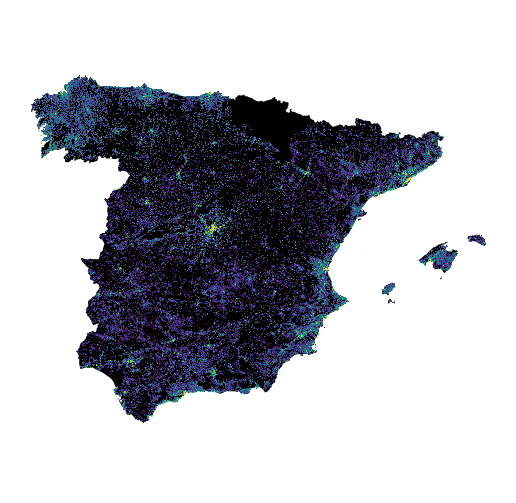

In [14]:
# datashader
cvs = ds.Canvas(plot_width=1920, plot_height=1080)
agg = cvs.points(one, 'X', 'Y', ds.sum('numberOfBuildingUnits'))
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], 
               how='log')
# numpy
a = np.flipud(img.values.astype(float))
mask = np.where(a==0)
a[mask] = np.nan
# matplotlib
ext = one[['X', 'Y']].describe()\
                          .loc[['min', 'max'], :]\
                          .T\
                          .stack()\
                          .values
f, ax = plt.subplots(1, figsize=(9, 9))
f.set_facecolor('w')
sp_one.plot(color='k', ax=ax)
ax.imshow(a, cmap='viridis_r', zorder=3, extent=ext)
ax.set_axis_off()
ax.axis('equal')

#plt.savefig('figures/revision/fig2.png', facecolor=BGCOLOR, dpi=900)
plt.show()

### Spain cities (*Fig. 5*)

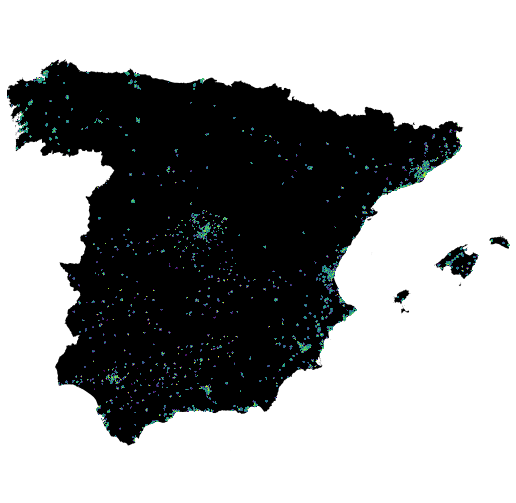

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
f.set_facecolor('w')
sp_one.plot(color='k', zorder=0, ax=ax)
ax.set_axis_off()
ax.axis('equal')
tools.shade_pts(one.query("lbls != -1")[['X', 'Y']],
                w=1920, h=1080,
                cmap='viridis_r',
                ax=ax)
#plt.savefig('figures/revision/fig5.png', facecolor='w', dpi=900)
plt.show()

### Barcelona region (*Fig. 6*)

CPU times: user 23.1 s, sys: 6.86 ms, total: 23.1 s
Wall time: 23.4 s


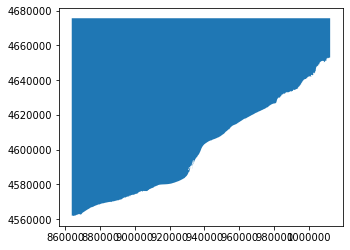

In [16]:
bcn_bbox = [863628.65407974, 4561862.736812, 
            1012299.36347845, 4675592.8827926]

bcn = one.loc[(bcn_bbox[0] < one['X']) & 
              (bcn_bbox[2] > one['X']) &
              (bcn_bbox[1] < one['Y']) & 
              (bcn_bbox[3] > one['Y'])
              , :]

#--- Background block ---#
minX, minY, maxX, maxY = bcn_bbox
bb_poly = Polygon([(minX, minY),
                   (maxX, minY),
                   (maxX, maxY),
                   (minX, maxY),
                   (minX, minY)
                  ])
bb_poly = geopandas.GeoDataFrame({'geometry': [bb_poly]},
                                 crs=gdb.crs)
%time bg_poly = geopandas.overlay(bb_poly, sp_one, how='intersection')
bg_poly.plot()

In [17]:
def plot_region(bbox, pts, boundaries=None, name=None,
                cmap=CMAP, boundary_color='#7570b3',
                bgcolor=BGCOLOR, saveto=None):
    f, ax = plt.subplots(1, figsize=(9, 9), facecolor=bgcolor)

    reg = one.loc[(bbox[0] < one['X']) & 
              (bbox[2] > one['X']) &
              (bbox[1] < one['Y']) & 
              (bbox[3] > one['Y'])
              , :]
    bg_poly.plot(color='k', zorder=0, ax=ax)
    tools.shade_pts(reg[['X', 'Y']], cmap=cmap,
                    w=900, h=900,
                    ax=ax, alpha=1)
    if boundaries is not None:
        minX, minY, maxX, maxY = bbox
        cts = boundaries.centroid
        area_boundaries = boundaries.loc[(cts.x > minX) &
                                         (cts.x < maxX) &
                                         (cts.y > minY) &
                                         (cts.y < maxY)]
        area_boundaries.boundary.plot(ax=ax, 
                                      color=boundary_color, 
                                      linewidth=1)
    if name:
        ax.set_title(name, color='k', fontsize=20,
                     bbox={'facecolor':'w', 'alpha':0.5, 'pad':1,
                           'edgecolor': 'w'})
    ax.axis('equal')
    ax.set_axis_off()
    ax.set_facecolor(bgcolor)
    
    if saveto:
        plt.savefig(saveto, dpi=900, facecolor=bgcolor)

    return f, ax

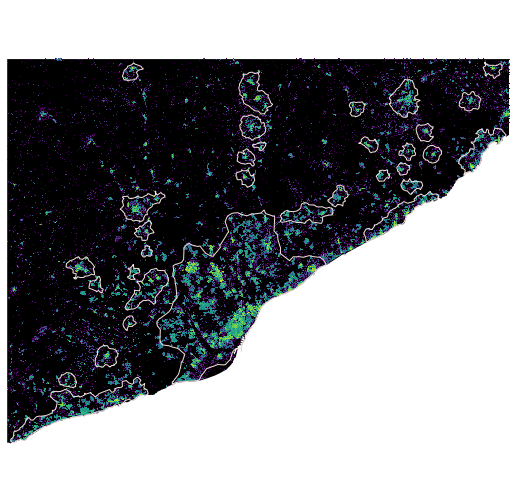

In [18]:
p = 'figures/revision/fig6.png'
plot_region(bcn_bbox, bcn, boundaries=gdb, name=None,
            cmap='viridis_r', bgcolor='w', boundary_color='#f2e2dd',
            saveto=None);

### Barcelona city employment centres (*Fig. 7*)

In [19]:
p = '../output/revision/rep1000_mp2000_eps2000_centres_adbscan.gpkg'
empc = geopandas.read_file(p)

In [20]:
def plot_city(city_id, pts, cities, bg_poly, centres, name=None,
              cmap=CMAP, bgcolor=BGCOLOR, 
              city_boundary_color='#7570b3', centre_boundary_color='red',
              saveto=None):
    f, ax = plt.subplots(1, figsize=(9, 9), facecolor=bgcolor)
    
    city = cities.query(f"lbls == {city_id}")
    # Shade buildings
    minX, minY, maxX, maxY = bg_poly.total_bounds
    city_pts = pts.query((f"(X > {minX}) & "\
                          f"(X < {maxX}) & "\
                          f"(Y > {minY}) & "\
                          f"(Y < {maxY})"))
    #city_pts = pts.loc[pts['lbls']==city_id, :]
    tools.shade_pts(city_pts[['X', 'Y', 'numberOfBuildingUnits']],
                    z='numberOfBuildingUnits',
                    w=900, h=900,
                    cmap=cmap, ax=ax, alpha=1)
    # Draw city boundary and poly
    bg_poly.plot(ax=ax,
                 color='k',
                 linewidth=1,
                 zorder=0)
    city.boundary.plot(color=city_boundary_color, ax=ax)
    # Draw centres
    centres_city = centres.loc[centres['city_id']==city_id, :]
    centres_city.boundary.plot(ax=ax,
                               color=centre_boundary_color)
    # Other
    if name:
        ax.set_title(name, color='k', fontsize=20,
                     bbox={'facecolor':'w', 'alpha':0.5, 'pad':1,
                           'edgecolor': 'w'})
    ax.axis('equal')
    ax.set_axis_off()
    ax.set_facecolor(bgcolor)
    
    if saveto:
        plt.savefig(saveto, dpi=500, facecolor=bgcolor)

    return f, ax

* All centres

CPU times: user 22.4 s, sys: 3.72 ms, total: 22.4 s
Wall time: 22.4 s


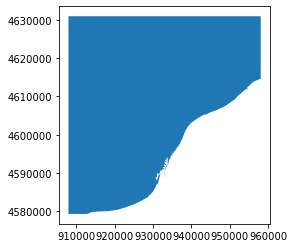

In [21]:
#--- Background block ---#
minX, minY, maxX, maxY = gdb.query("lbls == 15").total_bounds
bb_poly = Polygon([(minX, minY),
                   (maxX, minY),
                   (maxX, maxY),
                   (minX, maxY),
                   (minX, minY)
                  ])
bb_poly = geopandas.GeoDataFrame({'geometry': [bb_poly]},
                                 crs=gdb.crs)
%time bg_poly = geopandas.overlay(bb_poly, sp_one, how='intersection')
bg_poly.plot()

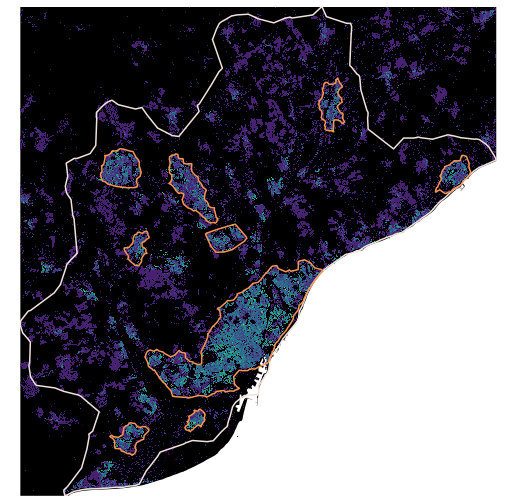

In [22]:
p = 'figures/revision/fig7.png'
plot_city(15, one, gdb, bg_poly,
          empc.query("city_id == 15")\
              .sort_values("n_pts", ascending=False)\
              .head(9),
          bgcolor='w', cmap='viridis_r', 
          city_boundary_color='#f2e2dd', 
          centre_boundary_color='#f89554',
          name=None,
          saveto=None);

### Overlap measures (*Fig. 8*)

These figures require additional data on top of building locations. Let's load them first:

In [23]:
%time xys = pandas.read_parquet('xys.parquet.gzip')

cities_path = "../output/revision/solution_rep1000_eps2000_mp2000_thr90.gpkg"
cities = geopandas.read_file(cities_path)\
                  .cx[:, 3500000:]\
                  .set_index('lbls')

munis_path = '../../01 AUDES/Municipios/audes2010-mun.shp'
munis = geopandas.read_file(munis_path)
munis.crs = {'init': 'epsg:4326'}
munis = munis.to_crs(cities.crs)\
         .cx[:, 3500000:]

%time sp_one_poly = munis.unary_union
sp_one = geopandas.GeoDataFrame({'geometry': [sp_one_poly]},
                                crs=munis.crs)

%time db = pandas.read_parquet('pts_multi_lbls.parquet').set_index('id')

CPU times: user 644 ms, sys: 581 ms, total: 1.23 s
Wall time: 2.75 s
CPU times: user 2min 54s, sys: 36 ms, total: 2min 54s
Wall time: 2min 55s
CPU times: user 4.59 s, sys: 5.99 s, total: 10.6 s
Wall time: 10.1 s


Let us define a method to create histograms and a transformed table of counts by A-DBSCAN city:

In [24]:
def count_in_our(deli, unit='areas'):
    out = db.query("lbls != -1")\
            .loc[:, ['lbls', deli]]\
            .drop_duplicates()\
            .groupby('lbls')\
            .size()
    out.index.name = f"Number of {unit}"
    return out

muni_in_au = db.loc[:, ['AU', 'CODINE']]\
               .dropna()\
               .drop_duplicates()\
               .groupby('AU')\
               .size()

- No. of AUDES in each of our A-DBSCAN areas - *Fig. 8 (a)*:

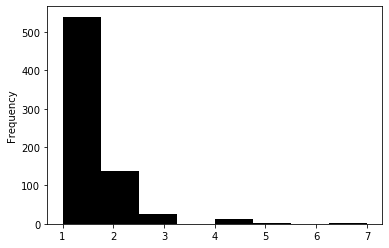

In [25]:
ax = count_in_our('AU').plot.hist(bins=8, color='k')
fig = ax.get_figure()
#fig.savefig('fig8a.png', dpi=300)

- No. of Municipalities in each of our A-DBSCAN areas - *Fig. 8 (c)*:

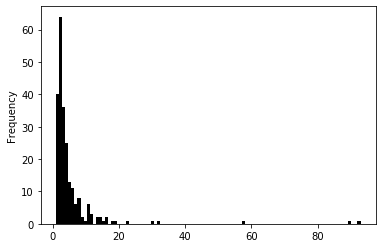

In [26]:
ax = muni_in_au.plot.hist(bins=100, color='k')
fig = ax.get_figure()
#fig.savefig('fig8c.png', dpi=300)

- Distribution of AUDES by A-DBSCAN areas - *Fig. 8 (b)*:

/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:138: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:140: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


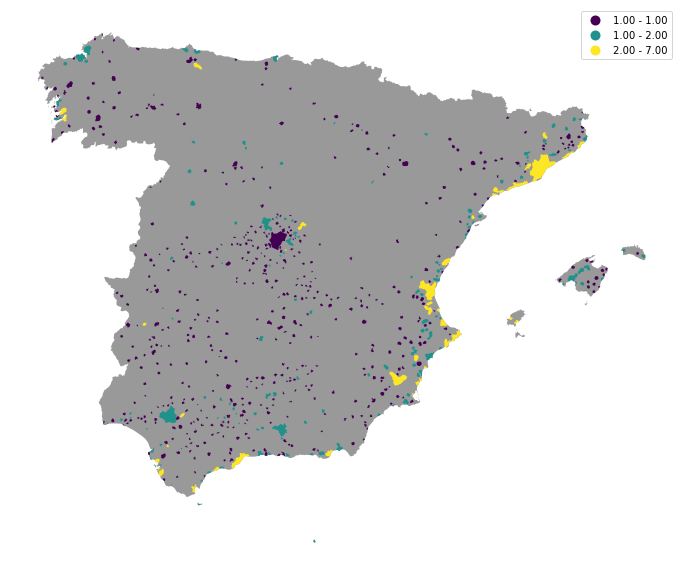

In [27]:
f, ax = plt.subplots(1, figsize=(12, 12))
sp_one.plot(ax=ax, color='0.6')
cities.assign(count=count_in_our('AU'))\
      .plot('count', scheme='quantiles', 
            legend=True, ax=ax)
ax.set_axis_off()
#f.savefig('fig8b.png', dpi=300)

- Distribution of Municipalities by A-DBSCAN areas - *Fig. 8 (d)*:

/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:140: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


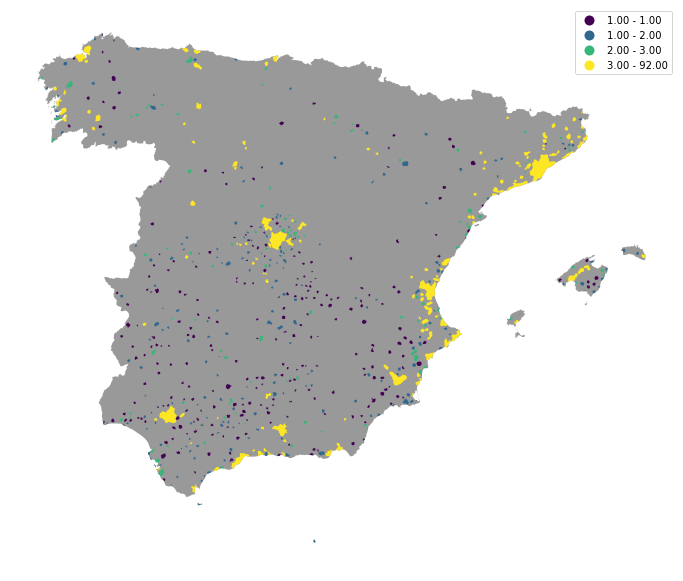

In [28]:
f, ax = plt.subplots(1, figsize=(12, 12))
sp_one.plot(ax=ax, color='0.6')
cities.assign(count=count_in_our('CODINE'))\
      .plot('count', scheme='quantiles', 
            legend=True, ax=ax)
ax.set_axis_off()
#f.savefig('fig8d.png', dpi=300)

### Appendix-B: Parameter sensibility (Spain)

In [29]:
def reader(f):
    db = pandas.read_feather(p+f)
    l = np.array([f.strip('sp_').strip('.feather')]*2)
    db.columns = pd.MultiIndex.from_arrays([l, db.columns])
    return db

def eps_mp2f(eps, mp):
    f = 'sp_mp%i_eps%s.gpkg'%(mp, eps)
    return f

epss = [1500, 1600, 1800, None, 2000, None, 2200, 2400, 2500]
epss = [1500, 1600, 1800, 2200, 2400, 2500]
min_pts = 2000

p = '../output/'

CPU times: user 11.2 s, sys: 5.09 s, total: 16.3 s
Wall time: 16 s


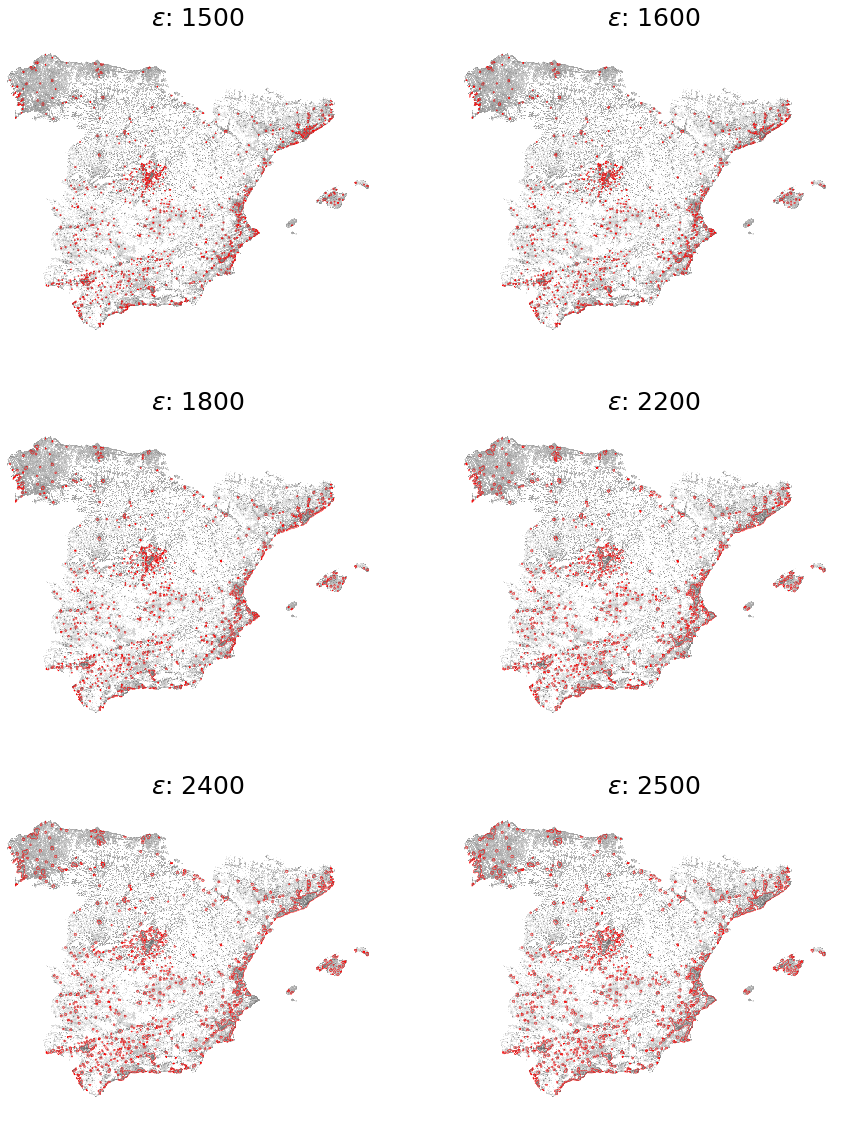

In [30]:
%%time

f, axs = plt.subplots(3, 2, figsize=(15, 20))
f.set_facecolor(BGCOLOR)
axs = axs.flatten()

for i in range(6):
    eps = epss[i]
    url = p + eps_mp2f(eps, min_pts)
    ax = axs[i]
    if eps:
        try:
            gdb = geopandas.read_file(url)
            gdb = gdb[gdb.centroid.y > YBOUND]
            tools.shade_pts(one[['X', 'Y']], cmap=CMAP, 
                            ax=ax, alpha=0.6)
            gdb.boundary.plot(ax=ax, color='red', linewidth=0.5)
            ax.set_title('$\epsilon$: %i'%(eps),
                         color='k', fontsize=25)
        except:
            print('eps: %i | min_pts: %i Not available | %s'\
                  %(eps, min_pts, url))
        ax.axis('equal')
    ax.set_axis_off()
    ax.set_facecolor(BGCOLOR)

#plt.savefig('figures/solutions.png', dpi=500, facecolor=BGCOLOR)